# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.GELU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 20, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=20, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 20, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Runtime measurement
train_time_start = time.process_time()
#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

train_time = time.process_time() - train_time_start
print('Training time:',train_time, 's')

Epoch 1/200, Iteration 1/12, Loss: 0.9718
Epoch 1/200, Iteration 2/12, Loss: 0.6918
Epoch 1/200, Iteration 3/12, Loss: 0.8928
Epoch 1/200, Iteration 4/12, Loss: 0.7058
Epoch 1/200, Iteration 5/12, Loss: 0.9572
Epoch 1/200, Iteration 6/12, Loss: 0.6822
Epoch 1/200, Iteration 7/12, Loss: 0.5211
Epoch 1/200, Iteration 8/12, Loss: 0.6350
Epoch 1/200, Iteration 9/12, Loss: 0.4432
Epoch 1/200, Iteration 10/12, Loss: 0.4599
Epoch 1/200, Iteration 11/12, Loss: 0.4778
Epoch 1/200, Iteration 12/12, Loss: 0.3780
Epoch 1/200, Iteration 13/12, Loss: 0.4608
Train Error: 
 Accuracy: 53.87%, Avg loss: 0.312690, MRE: 0.403325, MAE: 0.053059 

Test Error: 
 Accuracy: 56.5%, Avg loss: 0.292281, MRE: 0.284102, MAE: 0.047380 

Epoch 2/200, Iteration 1/12, Loss: 0.3221
Epoch 2/200, Iteration 2/12, Loss: 0.3543
Epoch 2/200, Iteration 3/12, Loss: 0.2832
Epoch 2/200, Iteration 4/12, Loss: 0.2314
Epoch 2/200, Iteration 5/12, Loss: 0.1622
Epoch 2/200, Iteration 6/12, Loss: 0.1642
Epoch 2/200, Iteration 7/12, Los

Test Error: 
 Accuracy: 88.5%, Avg loss: 0.017983, MRE: 0.064839, MAE: 0.010870 

Epoch 13/200, Iteration 1/12, Loss: 0.0383
Epoch 13/200, Iteration 2/12, Loss: 0.0184
Epoch 13/200, Iteration 3/12, Loss: 0.0159
Epoch 13/200, Iteration 4/12, Loss: 0.0160
Epoch 13/200, Iteration 5/12, Loss: 0.0164
Epoch 13/200, Iteration 6/12, Loss: 0.0102
Epoch 13/200, Iteration 7/12, Loss: 0.0297
Epoch 13/200, Iteration 8/12, Loss: 0.0147
Epoch 13/200, Iteration 9/12, Loss: 0.0188
Epoch 13/200, Iteration 10/12, Loss: 0.0194
Epoch 13/200, Iteration 11/12, Loss: 0.0154
Epoch 13/200, Iteration 12/12, Loss: 0.0245
Epoch 13/200, Iteration 13/12, Loss: 0.0409
Train Error: 
 Accuracy: 80.62%, Avg loss: 0.019479, MRE: 0.080850, MAE: 0.010459 

Test Error: 
 Accuracy: 84.0%, Avg loss: 0.017968, MRE: 0.064483, MAE: 0.010944 

Epoch 14/200, Iteration 1/12, Loss: 0.0399
Epoch 14/200, Iteration 2/12, Loss: 0.0180
Epoch 14/200, Iteration 3/12, Loss: 0.0161
Epoch 14/200, Iteration 4/12, Loss: 0.0249
Epoch 14/200, Ite

Epoch 24/200, Iteration 6/12, Loss: 0.0309
Epoch 24/200, Iteration 7/12, Loss: 0.0127
Epoch 24/200, Iteration 8/12, Loss: 0.0115
Epoch 24/200, Iteration 9/12, Loss: 0.0149
Epoch 24/200, Iteration 10/12, Loss: 0.0095
Epoch 24/200, Iteration 11/12, Loss: 0.0277
Epoch 24/200, Iteration 12/12, Loss: 0.0125
Epoch 24/200, Iteration 13/12, Loss: 0.0184
Train Error: 
 Accuracy: 87.75%, Avg loss: 0.014371, MRE: 0.062456, MAE: 0.008906 

Test Error: 
 Accuracy: 90.0%, Avg loss: 0.011951, MRE: 0.050907, MAE: 0.009212 

Epoch 25/200, Iteration 1/12, Loss: 0.0113
Epoch 25/200, Iteration 2/12, Loss: 0.0139
Epoch 25/200, Iteration 3/12, Loss: 0.0129
Epoch 25/200, Iteration 4/12, Loss: 0.0075
Epoch 25/200, Iteration 5/12, Loss: 0.0273
Epoch 25/200, Iteration 6/12, Loss: 0.0133
Epoch 25/200, Iteration 7/12, Loss: 0.0147
Epoch 25/200, Iteration 8/12, Loss: 0.0247
Epoch 25/200, Iteration 9/12, Loss: 0.0134
Epoch 25/200, Iteration 10/12, Loss: 0.0118
Epoch 25/200, Iteration 11/12, Loss: 0.0051
Epoch 25/20

Train Error: 
 Accuracy: 94.12%, Avg loss: 0.008394, MRE: 0.045421, MAE: 0.006731 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.006707, MRE: 0.036641, MAE: 0.006808 

Epoch 36/200, Iteration 1/12, Loss: 0.0049
Epoch 36/200, Iteration 2/12, Loss: 0.0063
Epoch 36/200, Iteration 3/12, Loss: 0.0165
Epoch 36/200, Iteration 4/12, Loss: 0.0105
Epoch 36/200, Iteration 5/12, Loss: 0.0037
Epoch 36/200, Iteration 6/12, Loss: 0.0073
Epoch 36/200, Iteration 7/12, Loss: 0.0147
Epoch 36/200, Iteration 8/12, Loss: 0.0027
Epoch 36/200, Iteration 9/12, Loss: 0.0100
Epoch 36/200, Iteration 10/12, Loss: 0.0079
Epoch 36/200, Iteration 11/12, Loss: 0.0052
Epoch 36/200, Iteration 12/12, Loss: 0.0057
Epoch 36/200, Iteration 13/12, Loss: 0.0174
Train Error: 
 Accuracy: 95.5%, Avg loss: 0.007370, MRE: 0.040017, MAE: 0.005862 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.005431, MRE: 0.032654, MAE: 0.006064 

Epoch 37/200, Iteration 1/12, Loss: 0.0050
Epoch 37/200, Iteration 2/12, Loss: 0.0043
Epoch 37/200, Iterat

Train Error: 
 Accuracy: 97.75%, Avg loss: 0.005004, MRE: 0.035117, MAE: 0.004718 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.004672, MRE: 0.027395, MAE: 0.004737 

Epoch 49/200, Iteration 1/12, Loss: 0.0048
Epoch 49/200, Iteration 2/12, Loss: 0.0057
Epoch 49/200, Iteration 3/12, Loss: 0.0029
Epoch 49/200, Iteration 4/12, Loss: 0.0081
Epoch 49/200, Iteration 5/12, Loss: 0.0017
Epoch 49/200, Iteration 6/12, Loss: 0.0089
Epoch 49/200, Iteration 7/12, Loss: 0.0024
Epoch 49/200, Iteration 8/12, Loss: 0.0045
Epoch 49/200, Iteration 9/12, Loss: 0.0102
Epoch 49/200, Iteration 10/12, Loss: 0.0029
Epoch 49/200, Iteration 11/12, Loss: 0.0034
Epoch 49/200, Iteration 12/12, Loss: 0.0019
Epoch 49/200, Iteration 13/12, Loss: 0.0097
Train Error: 
 Accuracy: 93.0%, Avg loss: 0.005105, MRE: 0.037075, MAE: 0.004800 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.003249, MRE: 0.026180, MAE: 0.004181 

Epoch 50/200, Iteration 1/12, Loss: 0.0051
Epoch 50/200, Iteration 2/12, Loss: 0.0080
Epoch 50/200, Iterat

Epoch 60/200, Iteration 9/12, Loss: 0.0040
Epoch 60/200, Iteration 10/12, Loss: 0.0078
Epoch 60/200, Iteration 11/12, Loss: 0.0031
Epoch 60/200, Iteration 12/12, Loss: 0.0070
Epoch 60/200, Iteration 13/12, Loss: 0.0028
Train Error: 
 Accuracy: 97.75%, Avg loss: 0.003778, MRE: 0.034091, MAE: 0.004538 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003288, MRE: 0.025279, MAE: 0.004167 

Epoch 61/200, Iteration 1/12, Loss: 0.0033
Epoch 61/200, Iteration 2/12, Loss: 0.0036
Epoch 61/200, Iteration 3/12, Loss: 0.0039
Epoch 61/200, Iteration 4/12, Loss: 0.0053
Epoch 61/200, Iteration 5/12, Loss: 0.0030
Epoch 61/200, Iteration 6/12, Loss: 0.0054
Epoch 61/200, Iteration 7/12, Loss: 0.0083
Epoch 61/200, Iteration 8/12, Loss: 0.0037
Epoch 61/200, Iteration 9/12, Loss: 0.0038
Epoch 61/200, Iteration 10/12, Loss: 0.0018
Epoch 61/200, Iteration 11/12, Loss: 0.0032
Epoch 61/200, Iteration 12/12, Loss: 0.0033
Epoch 61/200, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 90.0%, Avg loss: 0.005740, 

Train Error: 
 Accuracy: 98.12%, Avg loss: 0.003031, MRE: 0.030514, MAE: 0.004001 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.002579, MRE: 0.023897, MAE: 0.003936 

Epoch 73/200, Iteration 1/12, Loss: 0.0032
Epoch 73/200, Iteration 2/12, Loss: 0.0024
Epoch 73/200, Iteration 3/12, Loss: 0.0018
Epoch 73/200, Iteration 4/12, Loss: 0.0060
Epoch 73/200, Iteration 5/12, Loss: 0.0029
Epoch 73/200, Iteration 6/12, Loss: 0.0026
Epoch 73/200, Iteration 7/12, Loss: 0.0056
Epoch 73/200, Iteration 8/12, Loss: 0.0019
Epoch 73/200, Iteration 9/12, Loss: 0.0039
Epoch 73/200, Iteration 10/12, Loss: 0.0026
Epoch 73/200, Iteration 11/12, Loss: 0.0017
Epoch 73/200, Iteration 12/12, Loss: 0.0022
Epoch 73/200, Iteration 13/12, Loss: 0.0048
Train Error: 
 Accuracy: 95.38%, Avg loss: 0.003763, MRE: 0.055085, MAE: 0.004617 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.002610, MRE: 0.028635, MAE: 0.004207 

Epoch 74/200, Iteration 1/12, Loss: 0.0063
Epoch 74/200, Iteration 2/12, Loss: 0.0046
Epoch 74/200, Itera

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.002236, MRE: 0.027498, MAE: 0.003491 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.001729, MRE: 0.020310, MAE: 0.003439 

Epoch 86/200, Iteration 1/12, Loss: 0.0019
Epoch 86/200, Iteration 2/12, Loss: 0.0013
Epoch 86/200, Iteration 3/12, Loss: 0.0020
Epoch 86/200, Iteration 4/12, Loss: 0.0016
Epoch 86/200, Iteration 5/12, Loss: 0.0024
Epoch 86/200, Iteration 6/12, Loss: 0.0019
Epoch 86/200, Iteration 7/12, Loss: 0.0020
Epoch 86/200, Iteration 8/12, Loss: 0.0051
Epoch 86/200, Iteration 9/12, Loss: 0.0010
Epoch 86/200, Iteration 10/12, Loss: 0.0036
Epoch 86/200, Iteration 11/12, Loss: 0.0040
Epoch 86/200, Iteration 12/12, Loss: 0.0027
Epoch 86/200, Iteration 13/12, Loss: 0.0052
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.003111, MRE: 0.037229, MAE: 0.003979 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002882, MRE: 0.023382, MAE: 0.004091 

Epoch 87/200, Iteration 1/12, Loss: 0.0025
Epoch 87/200, Iteration 2/12, Loss: 0.0020
Epoch 87/200, Itera

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.001941, MRE: 0.026607, MAE: 0.003293 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.001693, MRE: 0.020999, MAE: 0.003491 

Epoch 98/200, Iteration 1/12, Loss: 0.0017
Epoch 98/200, Iteration 2/12, Loss: 0.0020
Epoch 98/200, Iteration 3/12, Loss: 0.0021
Epoch 98/200, Iteration 4/12, Loss: 0.0015
Epoch 98/200, Iteration 5/12, Loss: 0.0017
Epoch 98/200, Iteration 6/12, Loss: 0.0014
Epoch 98/200, Iteration 7/12, Loss: 0.0025
Epoch 98/200, Iteration 8/12, Loss: 0.0026
Epoch 98/200, Iteration 9/12, Loss: 0.0037
Epoch 98/200, Iteration 10/12, Loss: 0.0028
Epoch 98/200, Iteration 11/12, Loss: 0.0036
Epoch 98/200, Iteration 12/12, Loss: 0.0026
Epoch 98/200, Iteration 13/12, Loss: 0.0017
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.003078, MRE: 0.029110, MAE: 0.004189 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003119, MRE: 0.024387, MAE: 0.004626 

Epoch 99/200, Iteration 1/12, Loss: 0.0019
Epoch 99/200, Iteration 2/12, Loss: 0.0049
Epoch 99/200, Iterat

Train Error: 
 Accuracy: 99.0%, Avg loss: 0.001546, MRE: 0.022138, MAE: 0.003023 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001456, MRE: 0.018097, MAE: 0.003337 

Epoch 111/200, Iteration 1/12, Loss: 0.0011
Epoch 111/200, Iteration 2/12, Loss: 0.0016
Epoch 111/200, Iteration 3/12, Loss: 0.0017
Epoch 111/200, Iteration 4/12, Loss: 0.0038
Epoch 111/200, Iteration 5/12, Loss: 0.0029
Epoch 111/200, Iteration 6/12, Loss: 0.0011
Epoch 111/200, Iteration 7/12, Loss: 0.0022
Epoch 111/200, Iteration 8/12, Loss: 0.0008
Epoch 111/200, Iteration 9/12, Loss: 0.0027
Epoch 111/200, Iteration 10/12, Loss: 0.0034
Epoch 111/200, Iteration 11/12, Loss: 0.0011
Epoch 111/200, Iteration 12/12, Loss: 0.0017
Epoch 111/200, Iteration 13/12, Loss: 0.0019
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.001683, MRE: 0.024283, MAE: 0.003075 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001473, MRE: 0.018709, MAE: 0.003247 

Epoch 112/200, Iteration 1/12, Loss: 0.0010
Epoch 112/200, Iteration 2/12, Loss: 0.0024
Epoch

Train Error: 
 Accuracy: 99.0%, Avg loss: 0.001335, MRE: 0.021721, MAE: 0.002872 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001181, MRE: 0.016281, MAE: 0.003044 

Epoch 123/200, Iteration 1/12, Loss: 0.0015
Epoch 123/200, Iteration 2/12, Loss: 0.0014
Epoch 123/200, Iteration 3/12, Loss: 0.0012
Epoch 123/200, Iteration 4/12, Loss: 0.0014
Epoch 123/200, Iteration 5/12, Loss: 0.0024
Epoch 123/200, Iteration 6/12, Loss: 0.0017
Epoch 123/200, Iteration 7/12, Loss: 0.0023
Epoch 123/200, Iteration 8/12, Loss: 0.0010
Epoch 123/200, Iteration 9/12, Loss: 0.0008
Epoch 123/200, Iteration 10/12, Loss: 0.0026
Epoch 123/200, Iteration 11/12, Loss: 0.0011
Epoch 123/200, Iteration 12/12, Loss: 0.0014
Epoch 123/200, Iteration 13/12, Loss: 0.0005
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001509, MRE: 0.021290, MAE: 0.003025 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.001539, MRE: 0.018183, MAE: 0.003330 

Epoch 124/200, Iteration 1/12, Loss: 0.0016
Epoch 124/200, Iteration 2/12, Loss: 0.0017
Epoch

Train Error: 
 Accuracy: 99.38%, Avg loss: 0.001281, MRE: 0.019649, MAE: 0.002814 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001144, MRE: 0.015035, MAE: 0.002836 

Epoch 135/200, Iteration 1/12, Loss: 0.0009
Epoch 135/200, Iteration 2/12, Loss: 0.0023
Epoch 135/200, Iteration 3/12, Loss: 0.0012
Epoch 135/200, Iteration 4/12, Loss: 0.0012
Epoch 135/200, Iteration 5/12, Loss: 0.0011
Epoch 135/200, Iteration 6/12, Loss: 0.0018
Epoch 135/200, Iteration 7/12, Loss: 0.0013
Epoch 135/200, Iteration 8/12, Loss: 0.0007
Epoch 135/200, Iteration 9/12, Loss: 0.0007
Epoch 135/200, Iteration 10/12, Loss: 0.0011
Epoch 135/200, Iteration 11/12, Loss: 0.0029
Epoch 135/200, Iteration 12/12, Loss: 0.0009
Epoch 135/200, Iteration 13/12, Loss: 0.0004
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.001474, MRE: 0.019733, MAE: 0.002960 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.001198, MRE: 0.015977, MAE: 0.003079 

Epoch 136/200, Iteration 1/12, Loss: 0.0011
Epoch 136/200, Iteration 2/12, Loss: 0.0012
Epoch

Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001048, MRE: 0.018410, MAE: 0.002699 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000973, MRE: 0.015097, MAE: 0.003004 

Epoch 148/200, Iteration 1/12, Loss: 0.0010
Epoch 148/200, Iteration 2/12, Loss: 0.0017
Epoch 148/200, Iteration 3/12, Loss: 0.0008
Epoch 148/200, Iteration 4/12, Loss: 0.0013
Epoch 148/200, Iteration 5/12, Loss: 0.0008
Epoch 148/200, Iteration 6/12, Loss: 0.0007
Epoch 148/200, Iteration 7/12, Loss: 0.0016
Epoch 148/200, Iteration 8/12, Loss: 0.0006
Epoch 148/200, Iteration 9/12, Loss: 0.0006
Epoch 148/200, Iteration 10/12, Loss: 0.0011
Epoch 148/200, Iteration 11/12, Loss: 0.0014
Epoch 148/200, Iteration 12/12, Loss: 0.0024
Epoch 148/200, Iteration 13/12, Loss: 0.0007
Train Error: 
 Accuracy: 99.0%, Avg loss: 0.001091, MRE: 0.020270, MAE: 0.002770 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001050, MRE: 0.015661, MAE: 0.002922 

Epoch 149/200, Iteration 1/12, Loss: 0.0007
Epoch 149/200, Iteration 2/12, Loss: 0.0007
Epoch

Epoch 159/200, Iteration 11/12, Loss: 0.0008
Epoch 159/200, Iteration 12/12, Loss: 0.0017
Epoch 159/200, Iteration 13/12, Loss: 0.0012
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.001133, MRE: 0.020103, MAE: 0.002716 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001021, MRE: 0.015100, MAE: 0.002780 

Epoch 160/200, Iteration 1/12, Loss: 0.0008
Epoch 160/200, Iteration 2/12, Loss: 0.0006
Epoch 160/200, Iteration 3/12, Loss: 0.0014
Epoch 160/200, Iteration 4/12, Loss: 0.0009
Epoch 160/200, Iteration 5/12, Loss: 0.0007
Epoch 160/200, Iteration 6/12, Loss: 0.0009
Epoch 160/200, Iteration 7/12, Loss: 0.0007
Epoch 160/200, Iteration 8/12, Loss: 0.0007
Epoch 160/200, Iteration 9/12, Loss: 0.0014
Epoch 160/200, Iteration 10/12, Loss: 0.0017
Epoch 160/200, Iteration 11/12, Loss: 0.0015
Epoch 160/200, Iteration 12/12, Loss: 0.0014
Epoch 160/200, Iteration 13/12, Loss: 0.0009
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.000949, MRE: 0.017050, MAE: 0.002576 

Test Error: 
 Accuracy: 99.5%, Avg loss

Train Error: 
 Accuracy: 97.75%, Avg loss: 0.001517, MRE: 0.024411, MAE: 0.003088 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.001226, MRE: 0.016688, MAE: 0.002936 

Epoch 172/200, Iteration 1/12, Loss: 0.0015
Epoch 172/200, Iteration 2/12, Loss: 0.0011
Epoch 172/200, Iteration 3/12, Loss: 0.0020
Epoch 172/200, Iteration 4/12, Loss: 0.0013
Epoch 172/200, Iteration 5/12, Loss: 0.0014
Epoch 172/200, Iteration 6/12, Loss: 0.0021
Epoch 172/200, Iteration 7/12, Loss: 0.0016
Epoch 172/200, Iteration 8/12, Loss: 0.0010
Epoch 172/200, Iteration 9/12, Loss: 0.0017
Epoch 172/200, Iteration 10/12, Loss: 0.0011
Epoch 172/200, Iteration 11/12, Loss: 0.0015
Epoch 172/200, Iteration 12/12, Loss: 0.0014
Epoch 172/200, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 99.38%, Avg loss: 0.001293, MRE: 0.020349, MAE: 0.003404 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001127, MRE: 0.017371, MAE: 0.003248 

Epoch 173/200, Iteration 1/12, Loss: 0.0014
Epoch 173/200, Iteration 2/12, Loss: 0.0011
Epoc

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.000811, MRE: 0.016291, MAE: 0.002522 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000706, MRE: 0.012150, MAE: 0.002468 

Epoch 184/200, Iteration 1/12, Loss: 0.0020
Epoch 184/200, Iteration 2/12, Loss: 0.0005
Epoch 184/200, Iteration 3/12, Loss: 0.0006
Epoch 184/200, Iteration 4/12, Loss: 0.0008
Epoch 184/200, Iteration 5/12, Loss: 0.0008
Epoch 184/200, Iteration 6/12, Loss: 0.0008
Epoch 184/200, Iteration 7/12, Loss: 0.0007
Epoch 184/200, Iteration 8/12, Loss: 0.0006
Epoch 184/200, Iteration 9/12, Loss: 0.0018
Epoch 184/200, Iteration 10/12, Loss: 0.0007
Epoch 184/200, Iteration 11/12, Loss: 0.0014
Epoch 184/200, Iteration 12/12, Loss: 0.0012
Epoch 184/200, Iteration 13/12, Loss: 0.0016
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.001012, MRE: 0.017781, MAE: 0.002620 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000869, MRE: 0.012935, MAE: 0.002592 

Epoch 185/200, Iteration 1/12, Loss: 0.0010
Epoch 185/200, Iteration 2/12, Loss: 0.0005
Epoch

Train Error: 
 Accuracy: 99.25%, Avg loss: 0.000783, MRE: 0.016322, MAE: 0.002463 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000812, MRE: 0.013619, MAE: 0.002579 

Epoch 196/200, Iteration 1/12, Loss: 0.0006
Epoch 196/200, Iteration 2/12, Loss: 0.0006
Epoch 196/200, Iteration 3/12, Loss: 0.0008
Epoch 196/200, Iteration 4/12, Loss: 0.0010
Epoch 196/200, Iteration 5/12, Loss: 0.0004
Epoch 196/200, Iteration 6/12, Loss: 0.0017
Epoch 196/200, Iteration 7/12, Loss: 0.0008
Epoch 196/200, Iteration 8/12, Loss: 0.0009
Epoch 196/200, Iteration 9/12, Loss: 0.0007
Epoch 196/200, Iteration 10/12, Loss: 0.0013
Epoch 196/200, Iteration 11/12, Loss: 0.0016
Epoch 196/200, Iteration 12/12, Loss: 0.0012
Epoch 196/200, Iteration 13/12, Loss: 0.0010
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.000946, MRE: 0.018631, MAE: 0.002609 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.000990, MRE: 0.015030, MAE: 0.002741 

Epoch 197/200, Iteration 1/12, Loss: 0.0010
Epoch 197/200, Iteration 2/12, Loss: 0.0012
Epoc

#### Plots loss vs Epoch

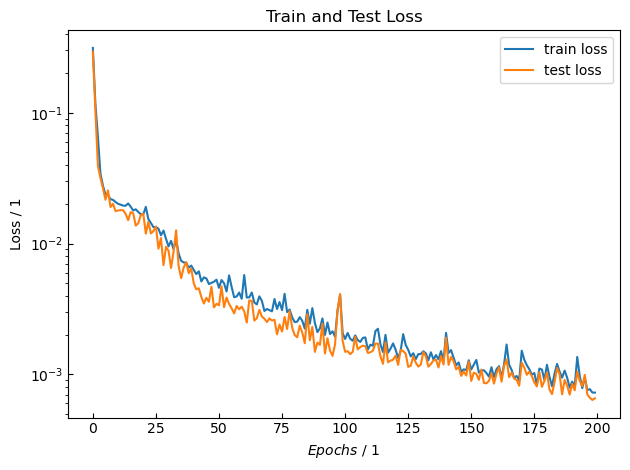

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9996134751735462 , R^2(NH3) = 0.9989317450635923
Test Dataset: R^2(H2) = 0.9994282914860156 , R^2(NH3) = 0.9990990309539349
Max Error Training: |x_H2 - x_H2,pred| = 0.01767867618579505 , |x_NH3 - x_NH3,pred| = 0.020684449180775222
Max Error Test: |x_H2 - x_H2,pred| = 0.017059976373713814 , |x_NH3 - x_NH3,pred| = 0.016791471814046055


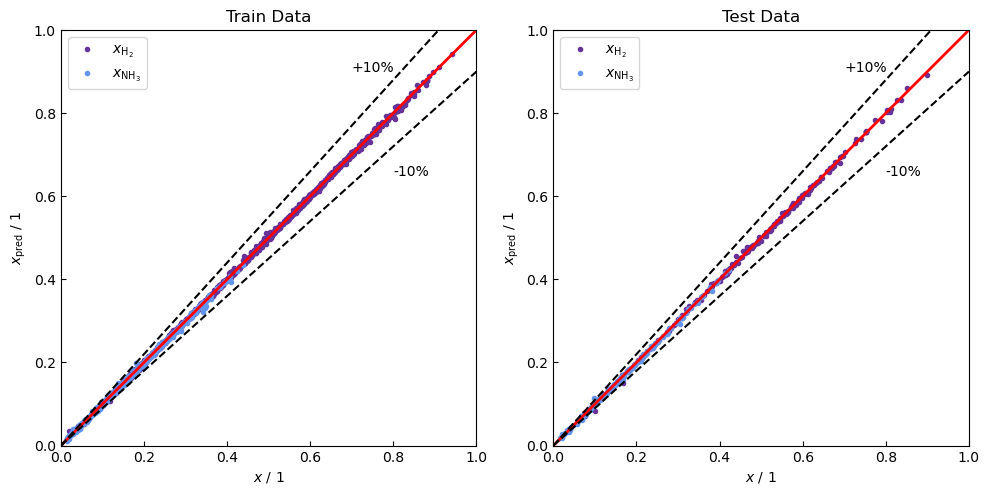

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

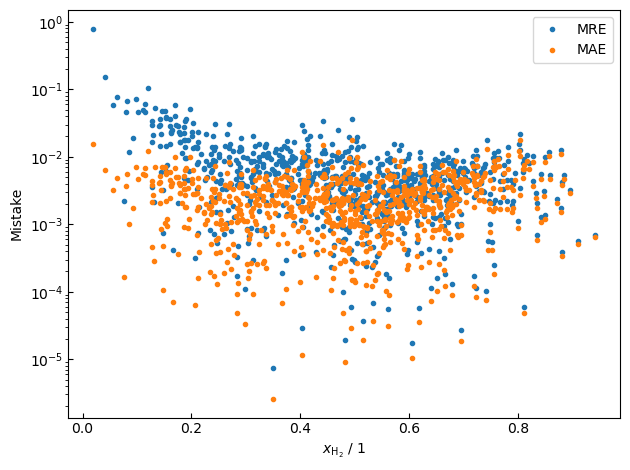

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

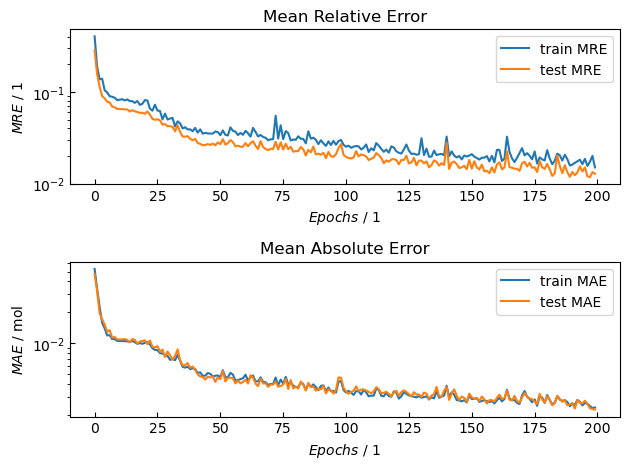

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

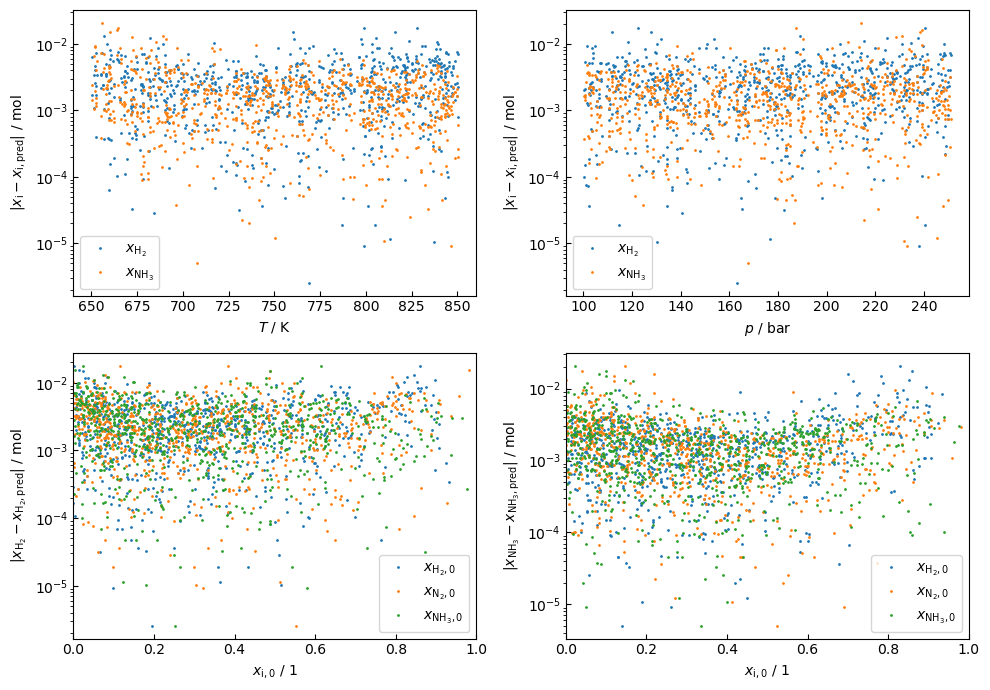

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

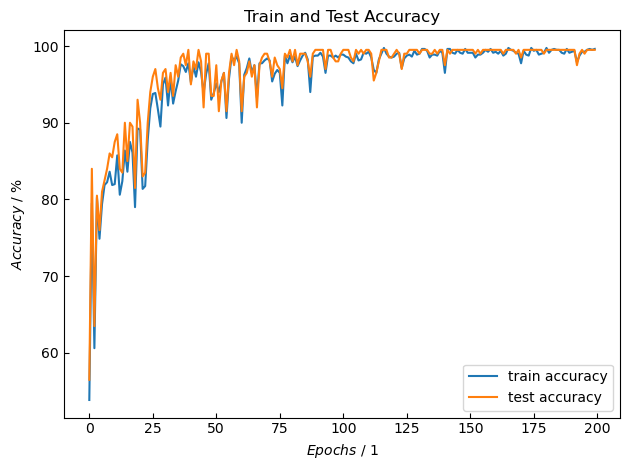

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Laufzeit Gleichgewichtsvorhersage

In [16]:
start_pred_time = time.process_time()
for X, y in train_dataloader:
            pred = net(X)
pred_time = (time.process_time() - start_pred_time)
print('Prediction time:', pred_time, 's')

Prediction time: 0.015625 s


#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 0.9566, -0.1432,  1.8299, -0.9175, -0.8581],
        [-1.0639, -0.1890, -1.3405, -0.2066,  1.5268],
        [ 0.3304, -1.2976,  0.6917, -0.9320,  0.2738],
        [-0.1311,  0.7007, -0.0128, -0.8538,  0.8852],
        [ 0.3586,  0.9616,  1.5749, -1.0438, -0.4787],
        [ 0.9901,  0.0046,  1.3258, -0.0246, -1.2759],
        [ 0.1993, -0.4285,  0.7691, -0.3588, -0.3880],
        [ 0.2353, -0.2784, -0.5924,  0.9041, -0.3426],
        [-0.2789, -0.1213, -0.6003, -1.2213,  1.8374],
        [-1.7582, -0.8439, -0.8637,  1.9956, -1.1920],
        [-0.6652,  0.2186,  1.1691,  0.1781, -1.3293],
        [-0.9353, -1.3773,  0.8422, -0.4756, -0.3404],
        [ 0.1501, -0.4753, -1.2199,  0.4591,  0.7280],
        [ 1.1288,  0.8881,  0.5062, -0.5823,  0.0983],
        [ 0.5498,  0.7641,  0.0537, -1.3762,  1.3538],
        [-0.9163,  0.5315,  1.1628, -1.2732,  0.1602],
        [ 0.1451, -1.0251, -0.5135,  1.5393, -1.0693],
        [ 1.4302, -0.5929, -1.2602, -0.1346,  1.3743],
        [ 

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-0.1951, -0.5607, -0.3413, -0.3333, -0.1217],
         [-0.5034,  0.1456, -0.2739,  0.3161, -0.2625],
         [ 0.3239,  0.0268,  0.7303, -0.5538,  0.3782],
         [-0.2745,  0.1955, -0.4185, -0.1425,  0.0074],
         [ 0.5415,  0.0187,  0.1180, -0.1381,  0.0889],
         [-0.7407,  0.1127,  0.4260, -0.3563, -0.0054],
         [-0.1481,  0.0927,  0.5108, -0.3913,  0.1698],
         [ 0.4496, -0.1810, -0.3040,  0.3382, -0.3137],
         [ 0.0936,  0.0820,  0.0509,  0.6074, -0.1092],
         [ 0.1265, -0.0470, -0.8218,  0.6275, -0.5214],
         [-0.0932, -0.0761,  0.2833,  0.4653, -0.0353],
         [-0.1893,  0.0303, -0.5302,  0.4321, -0.6738],
         [-0.7084,  0.1044,  0.0551,  0.0692,  0.2745],
         [ 0.4041, -0.2462, -0.2373, -0.3972, -0.1148],
         [ 0.0865,  0.4047, -0.1124,  0.0360,  0.0699],
         [ 0.3950, -0.3991,  0.3573, -0.5900,  0.0819],
         [-0.1386, -0.2145,  0.2324, -0.7651, -0.3572],
         [-0.6294,  0.169

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.9010, 0.4152, 0.5856, 0.7622, 0.9385],
        [0.3899, 0.9214, 0.4783, 0.2307, 0.1145]])
tensor([[ 2.2181e-01, -4.2720e-01],
        [ 1.5313e-01, -2.4284e-04]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    #print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-1.3805,  0.1357, -0.8486, -0.8917,  1.7442],
        [ 0.7204,  1.1810,  0.8973, -0.3259, -0.5475],
        [-0.6778, -1.2817,  0.3920,  0.2140, -0.6034],
        [-1.4594,  1.2893, -0.1086,  0.2232, -0.1216],
        [ 0.9047, -0.9357, -1.0592,  2.1913, -1.2002],
        [-1.2516,  0.5024, -1.3103,  0.0430,  1.2420],
        [ 0.8195, -1.0486, -0.9871,  0.0787,  0.8883],
        [ 1.4179,  1.6501,  1.4858, -1.1919, -0.2400],
        [-1.1637, -0.9049,  0.6959, -1.3622,  0.7094],
        [-0.8945, -0.0693, -0.7766,  2.1134, -1.3979],
        [-0.0703, -0.6792, -0.1325,  1.1644, -1.0600],
        [-1.2142,  0.3132, -1.1855,  1.9190, -0.7980],
        [ 1.1039,  0.7939, -0.8204,  0.8887, -0.1033],
        [ 0.1362, -0.0201,  0.9955,  0.0053, -0.9823],
        [ 0.5248,  1.6455,  2.4220, -1.3302, -1.0174],
        [ 0.9997, -0.5143, -0.5652, -0.1084,  0.6654],
        [-1.4871,  0.0722, -0.7211,  0.7122, -0.0203],
        [-0.1069, -0.2897,  0.1224, -0.0738, -0.0447],
        [-

#### Histogramme Verteilung von $xi$ und $x{_i}$

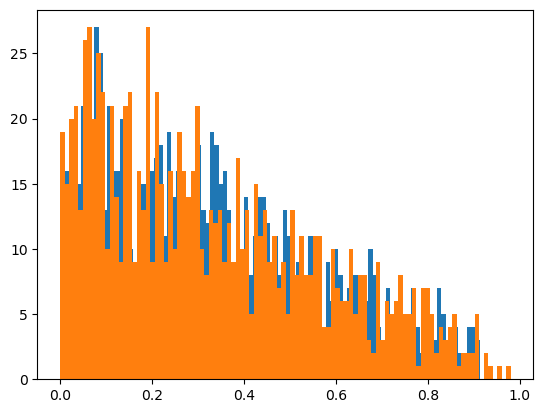

In [22]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()

#### Speichern des Modells

In [23]:
# torch.save(net.state_dict(),'data/models/ann_005_033.pth')
# np.savez('data/models/params_005_033.npz', mean_in = mean_in, std_in = std_in, mean_out = mean_out, std_out = std_out)